# Working with GeoTIFF and Shapefile data in Python

An example of working with GeoTIFF and Shapefile data in Python.

For these examples, we will look at data for the Snowdonia area of Wales, using elevation data from the file `tif/elev.tif`, and boundary information for the area from the Shapefile `shp/snowdonia.shp`

## Imports

Import required libraries for testing

In [1]:
# gdal for reading GeoTIFF data:
from osgeo import gdal
# xarray for reading GeoTIFF data:
import xarray as xr
# shapefile for reading Shapefile data:
import shapefile
# numpy for various calculations, etc.:
import numpy as np
# matplotlib and cartopy for plotting:
import matplotlib.pyplot as plt
import cartopy

## Define paths to data files

We will start by defining the paths to our data files.

In [2]:
# path to elevation GeoTIFF file:
elev_tif = 'tif/elev.tif'
# path to boundary Shapefile:
boundary_shp = 'shp/snowdonia.shp'

## Reading GeoTIFF data with GDAL

The GDAL Python library can be used to read GeoTIFF data and extra the coordinate and projection information.

this process requires multiple steps.

In [3]:
# set GDAL UseExecptions(), which will be the default in future versions.
# setting this here avoids a warning message:
gdal.UseExceptions()

# open the GeoTIFF file:
elev_raster = gdal.Open(elev_tif)
# read the ice velocity data in to a NumPy array:
elev_data = elev_raster.ReadAsArray()

# print some information about the data:
print(elev_data.shape)
print(elev_data.max())

(2401, 1601)
1574.1019


In [4]:
# prin some information about the coordinates and projection of the data:
print(elev_raster.GetSpatialRef())
print(elev_raster.GetGeoTransform())

GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AXIS["Latitude",NORTH],
    AXIS["Longitude",EAST],
    AUTHORITY["EPSG","4326"]]
(-5.000625, 0.00125, 0.0, 54.000416666666666, 0.0, -0.0008333333333333334)


The [GDAL documentation](https://gdal.org/tutorials/geotransforms_tut.html) provides lots of information about GeoTransforms.

We can work out the lat (y) and lon (x) coordinates of each pixel, using the GeoTransform information.

The first value in the GeoTransform data is x coordinate of the upper left pixel, and the second value is the difference between each pixel x coordinate. The fourth value is the y coordinate of the upper left pixel and the sixth value is the difference between each y pixel coordinate.

With this information we can work out the lat and lon values.

In [5]:
# Get the GeoTIFF GeoTransform:
elev_gt = elev_raster.GetGeoTransform()

# The number of lat coordinates is the first value in elev_data.shape:
elev_lat_sz = elev_data.shape[0]
# Create an array of pixel index values:
elev_lat_indexes = np.arange(0, elev_lat_sz)
# Get the minimum lat value and the lat increment value:
elev_lat_min = elev_gt[3]
elev_lat_inc = elev_gt[5]
# Work out the lat coordinate values:
elev_lat = elev_lat_min + (elev_lat_indexes * elev_lat_inc)

# The number of lon coordinates is the second value in elev_data.shape:
elev_lon_sz = elev_data.shape[1]
# Create an array of pixel index values:
elev_lon_indexes = np.arange(0, elev_lon_sz)
# Get the minimum lon value and the lon increment value:
elev_lon_min = elev_gt[0]
elev_lon_inc = elev_gt[1]
# Work out the lon coordinate values:
elev_lon = elev_lon_min + (elev_lon_indexes * elev_lon_inc)

We can find the no data value, and set any pixels with no data to have NaN value.

In [6]:
# Check the no data value:
elev_nodata = elev_raster.GetRasterBand(1).GetNoDataValue()
print('No data value: ', elev_nodata)
# Set no data values to NaN:
elev_data[elev_data == elev_nodata] = np.nan

No data value:  None


In this case, there is not a _No Data_ value, so nothing has been updated.

Now we have the data and coordinate information, we can create a georeferenced plot using cartopy.

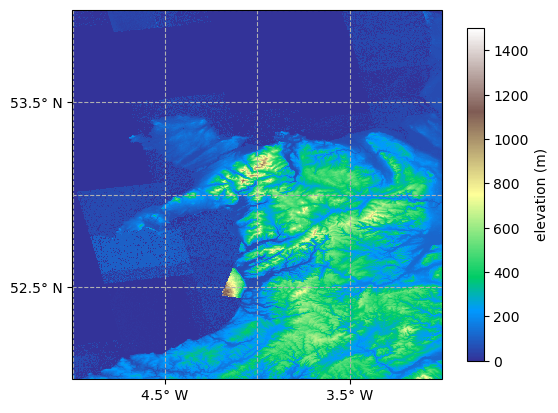

In [7]:
# set map projection:
map_projection = cartopy.crs.PlateCarree()
# create the plot axes:
map_axes = plt.axes(projection=map_projection)
# add gridlines to the map:
map_axes.gridlines(
    draw_labels=False,
    linestyle='--',
    xlocs=np.arange(-5, -2, 0.5),
    ylocs=np.arange(52, 55, 0.5)
)
# add some ticks and tick labels to the axes
map_axes.set_xticks([-4.5, -3.5])
map_axes.set_xticklabels(['4.5° W', '3.5° W'])
map_axes.set_yticks([52.5, 53.5])
map_axes.set_yticklabels(['52.5° N', '53.5° N'])
# plot the elevation data:
elev_plot = map_axes.pcolormesh(
    elev_lon,
    elev_lat,
    elev_data,
    cmap='terrain',
    vmin=0,
    vmax=1500
)
# add a colour scale:
cbar = plt.colorbar(elev_plot, shrink=0.9)
# set the colour bar label:
cbar.set_label('elevation (m)')

## Reading GeoTIFF data with Rasterio and xarray

A simpler way to access GeoTIFF data is to with xarray, which uses the `rasterio` and `rioxarray` software to read these files.

In [8]:
# read the GeoTIFF data with xarray:
elev_xr = xr.open_dataset(elev_tif)
# display xarray information:
elev_xr

<xarray.Dataset>
Dimensions:      (band: 1, x: 1601, y: 2401)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -5.0 -4.999 -4.997 -4.996 ... -3.002 -3.001 -3.0
  * y            (y) float64 54.0 54.0 54.0 54.0 54.0 ... 52.0 52.0 52.0 52.0
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [9]:
# there is only one band in this data so we can use squeeze('band') to
# remove this dimension:
elev_xr = elev_xr.squeeze('band')
# rename the 'band_data' to something more meaningful:
elev_xr = elev_xr.rename({'band_data': 'elev'})
# display xarray information:
elev_xr

<xarray.Dataset>
Dimensions:      (x: 1601, y: 2401)
Coordinates:
    band         int64 1
  * x            (x) float64 -5.0 -4.999 -4.997 -4.996 ... -3.002 -3.001 -3.0
  * y            (y) float64 54.0 54.0 54.0 54.0 54.0 ... 52.0 52.0 52.0 52.0
    spatial_ref  int64 ...
Data variables:
    elev         (y, x) float32 ...

Once the data has been loaded with rasterio + xarray, we can easily extract coordinate and data values and plot

In [10]:
# extract lats, lons and elevations from xarray:
elev_lats = elev_xr.y
elev_lons = elev_xr.x
elev_data = elev_xr.elev

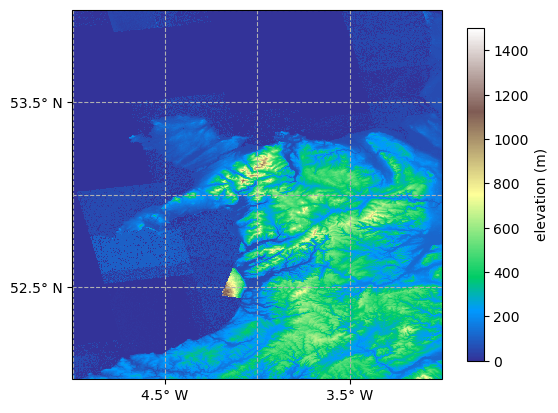

In [11]:
# set map projection:
map_projection = cartopy.crs.PlateCarree()
# create the plot axes:
map_axes = plt.axes(projection=map_projection)
# add gridlines to the map:
map_axes.gridlines(
    draw_labels=False,
    linestyle='--',
    xlocs=np.arange(-5, -2, 0.5),
    ylocs=np.arange(52, 55, 0.5)
)
# add some ticks and tick labels to the axes
map_axes.set_xticks([-4.5, -3.5])
map_axes.set_xticklabels(['4.5° W', '3.5° W'])
map_axes.set_yticks([52.5, 53.5])
map_axes.set_yticklabels(['52.5° N', '53.5° N'])
# plot the elevation data:
elev_plot = map_axes.pcolormesh(
    elev_lon,
    elev_lat,
    elev_data,
    cmap='terrain',
    vmin=0,
    vmax=1500
)
# add a colour scale:
cbar = plt.colorbar(elev_plot, shrink=0.9)
# set the colour bar label:
cbar.set_label('elevation (m)')

## Reading shapefile data with pyshp

The pyshp library can be imported with `import shapefile`, and we can then use this
to read Shapefil data

In [12]:
# read in in Shapefile data with the shapefile.Reader:
shp_reader = shapefile.Reader(boundary_shp)
# print some information about the Shapefile data:
print(shp_reader)

shapefile Reader
    1 shapes (type 'POLYGON')
    1 records (7 fields)


This shapefile contains a single shape. From this shapefile, we can extract the coordinates

In [13]:
# get all shapes from the Shapefile:
shp_shapes = shp_reader.shapes()
# the polygon for the area boundary is the first / only shape in this file;
boundary_shp = shp_shapes[0]
# see how many parts are in this shapefile:
boundary_parts = boundary_shp.parts
print(boundary_parts)

[0, 10255, 11313, 11371]


This shapefile contains four parts, with `boundary_parts` containing the starting
index of each polygon, so we have to extract the coordinates for each part separately,
and we will store these in lists.

In [14]:
# init lists for storing lat and lon values:
boundary_lats = []
boundary_lons = []
# get all of the coordinates from the shape points property:
boundary_points = boundary_shp.points
# loop through boundary_parts to get the starting index of each part:
for i, start_index in enumerate(boundary_parts):
    # if this is the last part end index is last value in points:
    if start_index == boundary_parts[-1]:
        boundary_lats.append([
            i[1] for i in boundary_points[start_index:]
        ])
        boundary_lons.append([
            i[0] for i in boundary_points[start_index:]
        ])
    # else, get end_index from the parts:
    else:
        end_index = boundary_parts[i + 1]
        boundary_lats.append([
            i[1] for i in boundary_points[start_index:end_index]
        ])
        boundary_lons.append([
            i[0] for i in boundary_points[start_index:end_index]
        ])

We now have lists containing fours sets of lat and lon values for the area boundary,
and we can recreate the elevation plot, adding the area boundary from the Shapefile

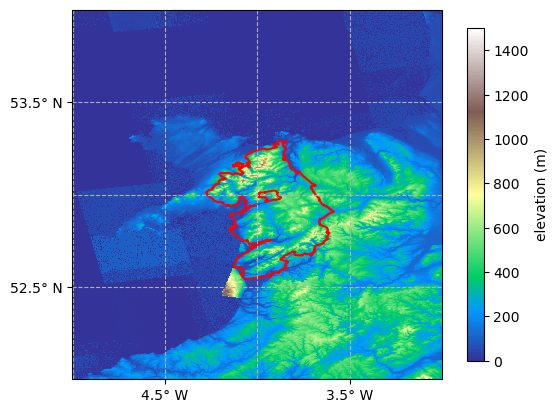

In [15]:
# set map projection:
map_projection = cartopy.crs.PlateCarree()
# create the plot axes:
map_axes = plt.axes(projection=map_projection)
# add gridlines to the map:
map_axes.gridlines(
    draw_labels=False,
    linestyle='--',
    xlocs=np.arange(-5, -2, 0.5),
    ylocs=np.arange(52, 55, 0.5)
)
# add some ticks and tick labels to the axes
map_axes.set_xticks([-4.5, -3.5])
map_axes.set_xticklabels(['4.5° W', '3.5° W'])
map_axes.set_yticks([52.5, 53.5])
map_axes.set_yticklabels(['52.5° N', '53.5° N'])
# plot the elevation data:
elev_plot = map_axes.pcolormesh(
    elev_lon,
    elev_lat,
    elev_data,
    cmap='terrain',
    vmin=0,
    vmax=1500
)
# add a colour scale:
cbar = plt.colorbar(elev_plot, shrink=0.9)
# set the colour bar label:
cbar.set_label('elevation (m)')

# loop through the sets of lat and lon values from the boundary Shapefile:
for i, boundary_lat in enumerate(boundary_lats):
    # get the lon values:
    boundary_lon = boundary_lons[i]
    # plot the boundary shape:
    map_axes.plot(
        boundary_lon,
        boundary_lat,
        color='red'
    )